## Multilabel_goemotions

In [ ]:
%config Completer.use_jedi=False
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


## Install package

In [ ]:
!pip install datasets
!pip install tqdm
!pip install tez
!pip install transformers

     |████████████████████████████████| 298 kB 12.6 MB/s 
     |████████████████████████████████| 132 kB 36.0 MB/s 
     |████████████████████████████████| 243 kB 49.5 MB/s 
     |████████████████████████████████| 1.1 MB 47.7 MB/s 
     |████████████████████████████████| 61 kB 453 kB/s 
     |████████████████████████████████| 271 kB 50.2 MB/s 
     |████████████████████████████████| 160 kB 44.5 MB/s 
     |████████████████████████████████| 192 kB 49.4 MB/s 
     |████████████████████████████████| 3.3 MB 13.0 MB/s 
     |████████████████████████████████| 3.3 MB 47.6 MB/s 
     |████████████████████████████████| 895 kB 23.6 MB/s 
     |████████████████████████████████| 596 kB 52.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
_CLASS_NAMES = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral",
]

mapping = dict(zip(range(len(_CLASS_NAMES)),_CLASS_NAMES))

## Import library

In [ ]:
from datasets import load_dataset

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


## Data preprocessing

In [ ]:

go_emotions = load_dataset("go_emotions")
device = torch.device("cuda")
data = go_emotions.data

train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

# train.head(10)
n_labels = len(mapping)

def one_hot_labels(df):
    dict_labels = []
    for i in tqdm(range(len(df)), leave=False):
        d = dict(zip(range(n_labels), [0]*n_labels))
        labels = df.loc[i]["labels"]
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
    df_labels = pd.DataFrame(dict_labels)
    return df_labels

train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)
train_oh_labels.shape

train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

print(train.shape, valid.shape, test.shape)

print(train.head())





Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No config specified, defaulting to: go_emotions/simplified


Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/201k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

(43410, 31) (5426, 31) (5427, 31)
                                                                                                               text  ... 27
0  My favourite food is anything I didn't have to cook myself.                                                       ...  1
1  Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead  ...  1
2  WHY THE FUCK IS BAYLESS ISOING                                                                                    ...  0
3  To make her feel threatened                                                                                       ...  0
4  Dirty Southern Wankers                                                                                            ...  0

[5 rows x 31 columns]


## Plot

In [ ]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")


fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")


## Build the Model ( Fine-tune )

In [ ]:

def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]

    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")


class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]

        inputs = self.tokenizer.encode_plus(text,
                           None,
                           add_special_tokens=True,
                           max_length=self.max_len,
                           padding="max_length",
                           truncation=True)

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }


class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"

    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt

    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch

    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())

    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}

        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()

        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}

    def forward(self, ids, mask, targets=None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc



train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist())
valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist())


n_train_steps = int(len(train) / 32 * 10)
model = EmotionClassifier(n_train_steps, n_labels)


NameError: ignored

## Train the model

In [ ]:

tb_logger = tez.callbacks.TensorBoardLogger(log_dir="logs/")
es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="./model.bin")


model.fit(train_dataset,
          valid_dataset, 
          train_bs=64,
          device="cuda", 
          epochs=6, 
          callbacks=[tb_logger, es], 
          fp16=True, 
          n_jobs=8)


test_dataset = GoEmotionDataset(test.text.tolist(), test[range(n_labels)].values.tolist())
dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/340 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 340/340 [01:27<00:00,  3.90it/s,

Validation score improved (inf --> 0.1280552840408157). Saving model!


  0%|          | 0/679 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/340 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|█████

Validation score improved (0.1280552840408157 --> 0.10387567969806054). Saving model!


  0%|          | 0/679 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/340 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|█████

Validation score improved (0.10387567969806054 --> 0.09654926307061139). Saving model!


  0%|          | 0/679 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/340 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|█████

Validation score improved (0.09654926307061139 --> 0.0910678594647085). Saving model!


  0%|          | 0/679 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/340 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|█████

Validation score improved (0.0910678594647085 --> 0.08934892140986288). Saving model!


  0%|          | 0/679 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/340 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|█████

Validation score improved (0.08934892140986288 --> 0.08760542950647719). Saving model!


## Predict

  0%|          | 0/85 [00:00<?, ?it/s]

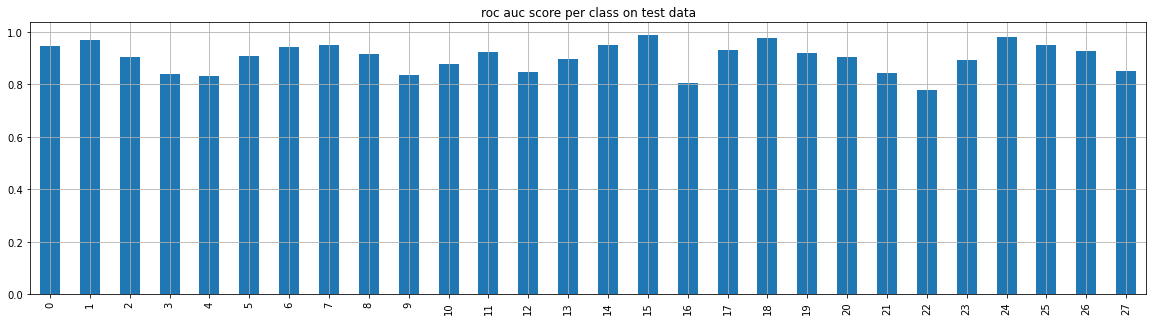

In [ ]:

outputs = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        output, loss, acc = model.forward(batch["ids"].to("cuda"),
                                          batch["mask"].to("cuda"),
                                          #batch["token_type_ids"].to("cuda"),
                                          batch["targets"].to("cuda")
                                         )
        outputs.append(output)


outputs = torch.cat(outputs)
outputs = torch.sigmoid(outputs)
outputs = outputs.cpu().detach().numpy()

roc_metrics = []

for i in range(n_labels):
    roc = metrics.roc_auc_score(test[i].values, outputs[:, i])
    roc_metrics.append(roc)

s = pd.Series(roc_metrics, index=range(n_labels))

s.plot(kind="bar", figsize=(20, 5), title="roc auc score per class on test data", grid=True)


tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )


def score_sentence(text, topn=3):
    max_len = 35
    with torch.no_grad():

        inputs = tokenizer.encode_plus(text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        padding="max_length",
        truncation=True)
        ids = inputs["input_ids"]
        ids = torch.LongTensor(ids).cuda().unsqueeze(0)

        attention_mask = inputs["attention_mask"]
        attention_mask = torch.LongTensor(attention_mask).cuda().unsqueeze(0)

        output = model.forward(ids, attention_mask)[0]
        output = torch.sigmoid(output)

        probas, indices = torch.sort(output)

    probas = probas.cpu().numpy()[0][::-1]
    indices = indices.cpu().numpy()[0][::-1]

    for i, p in zip(indices[:topn], probas[:topn]):
        print(mapping[i], p)




In [ ]:
score_sentence("you might have a point, but i strongly disagree with you")


In [ ]:
score_sentence("i'm feeling very confident about this situation")

In [ ]:
score_sentence("so insanely psyched to be putting out new music again! im gonna be reading and responding to a bunch of the comments later tonight so lmk what u think :)")